In [27]:
from training import GNNModel
import torch
from esm2 import get_embeddings
from processing import pdb_extractor
from data_prep import create_data_object

In [28]:
def run_inference(pdb_file):

    node_input_dim = 320 + 1
    edge_input_dim = 1
    hidden_dim = 128
    model = GNNModel(node_input_dim, edge_input_dim, hidden_dim)
    model.load_state_dict(torch.load('gnn_model_100_8_5.pth'))
    model.eval()

    results = pdb_extractor(pdb_file)
    sequence_embeddings = get_embeddings(results["Full Sequence"])
    
    data = create_data_object(results, sequence_embeddings)
    
    global labels;
    labels = (torch.tensor(results['Distance matrix'], dtype=torch.float) < 8.0).float()

    device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
    data = data.to(device)
    model.to(device)

    with torch.no_grad():
        edge_logits = model(data)
        edge_probs = torch.sigmoid(edge_logits)

    edge_preds = (edge_probs >= 0.5).float()
    
    global prob_matrix;
    prob_matrix = reconstruct_contact_matrix(edge_probs, data)

    contact_matrix_pred = reconstruct_contact_matrix(edge_preds, data)
    return contact_matrix_pred

def reconstruct_contact_matrix(edge_preds, data):
    num_nodes = data.num_nodes
    contact_matrix = torch.zeros((num_nodes, num_nodes), device=edge_preds.device)

    row, col = data.edge_index

    contact_matrix[row, col] = edge_preds
    contact_matrix[col, row] = edge_preds

    return contact_matrix.cpu().numpy()

In [29]:
pdb_file = "pdb_files/180L.pdb"
predicted_contact_matrix = run_inference(pdb_file)
# print(predicted_contact_matrix)

/tmp/ipykernel_28502/806551552.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('gnn_model_100_8_5.pth'))


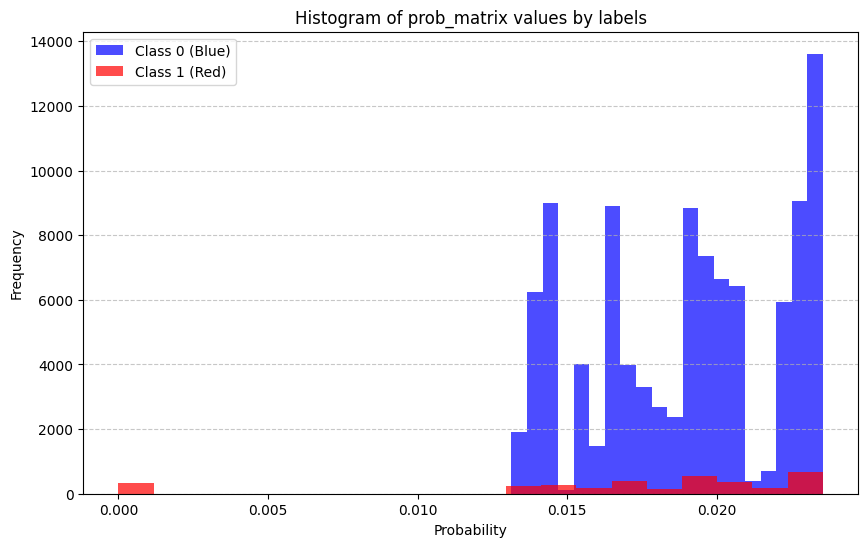

In [30]:
import matplotlib.pyplot as plt

labels_np = labels.numpy()

# Separate probabilities based on labels
prob_class_0 = prob_matrix[labels_np == 0]
prob_class_1 = prob_matrix[labels_np == 1]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(prob_class_0, bins=20, color='blue', alpha=0.7, label='Class 0 (Blue)')
plt.hist(prob_class_1, bins=20, color='red', alpha=0.7, label='Class 1 (Red)')
plt.title("Histogram of prob_matrix values by labels")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

If we need to be sure that the predictions of class 1 are always right, so we will not predict 1 for any point which belongs to 0 we can define threshold suppose 0.01 (when the model tells that there is a connection between two residues, it is always correct). By this way the precision will be 1.